### Exploritory Data Analysis:

**After I have done the basic data clean-up it was time to explore the data using different analytical plots. 
EDA is very important because it allows me to explore deeper into the dataset and find important quantities, features, and correlations. With the help of these findings not only would I be able to supply my future machine learning models with higher data quality but also, reinforce one's knowledge on the general performance of the product to which the data is related to**

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

movie_metadata = pd.read_csv("movies_md.csv")
ratings = pd.read_csv("ratings_nw.csv")

In [2]:
#creating copies of the data sets
mmd = movie_metadata.copy()
rts = ratings.copy()

In [3]:
#renaming the 'id' column to 'movieId' for convenience
mmd.rename(columns={"id": "movieId"}, inplace=True)

In [4]:
#Merging movies data and ratings data on 'movieId' column 
movie_data = pd.merge(rts, mmd, on='movieId')

In [5]:
movie_data.head()

,userId,movieId,rating,timestamp,genres,title
0,1,110,1.0,1425941529,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
1,11,110,3.5,1231676989,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
2,22,110,5.0,1111937009,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
3,24,110,5.0,979870012,"['Drama', 'Mystery', 'Romance']",Three Colors: Red
4,29,110,3.0,1044020005,"['Drama', 'Mystery', 'Romance']",Three Colors: Red


In [6]:
# Basic Analysis
T = len(rts['userId'].unique()) # Total number of registered users
TA = len(movie_data['userId'].unique()) # Total number of active users
C = movie_data['rating'].mean() # Global average rating   
AM = len(mmd['title'].unique()) # Total amount of movies on the platform
TV = movie_data['userId'].count() # Total number of votes 
MGR1 = movie_data.groupby('userId')['rating'].count().max() # Maximum votes given by a user
MGR2 = movie_data.groupby('userId')['rating'].count().min() # Minimum votes given by a user

print("Total number of registered users: {}".format(T))
print("Total number of active users: {}".format(TA))
print("Global average rating: {:.2f}".format(C))
print("Total amount of movies on the platform: {}".format(AM))
print("Total number of registered votes: {}".format(TV))
print("Maximum votes given by a user {}".format(MGR1))
print("Minimum votes given by a user {}".format(MGR2))

Total number of registered users: 270896
Total number of active users: 265917
Global average rating: 3.53
Total amount of movies on the platform: 42277
Total number of registered votes: 11436568
Maximum votes given by a user 3593
Minimum votes given by a user 1


#### insights:
**1.** There are 4979 inactive registered users (users that did not vote even once)<br>
**2.** The overall movie quality is above average and/or users are pretty generous when it comes to rating<br>
**3.** Each active user gave 40 votes on average

In [7]:
# Advanced Analysis 
# creating a new dataframe which consists of movie titles, average rating for the movie and total number of votes for the movie
ratings_avg_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_avg_count['number_of_votes'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
ratings_avg_count.head()

,rating,number_of_votes
title,,
!Women Art Revolution,2.802945,883
"$1,000 on the Black",3.000000,1
$5 a Day,2.246795,156
'Gator Bait,3.443590,195
'R Xmas,2.627907,86


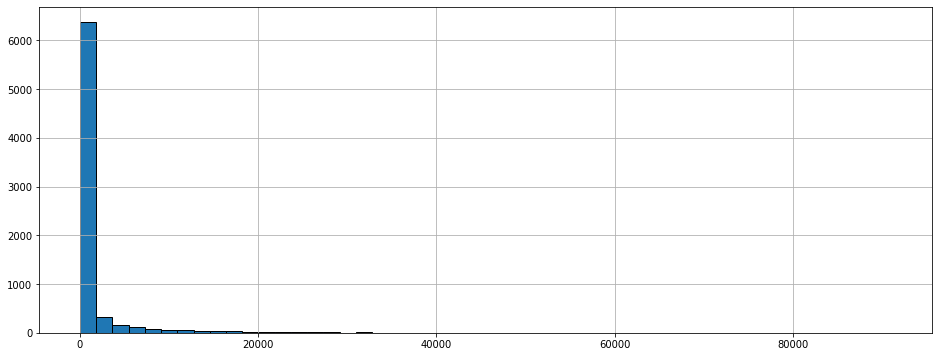

In [47]:
plt.figure(figsize=(16,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_avg_count['number_of_votes'].hist(bins=50)
plt.show()

**Most of the movies on the platform have around 50 votes**

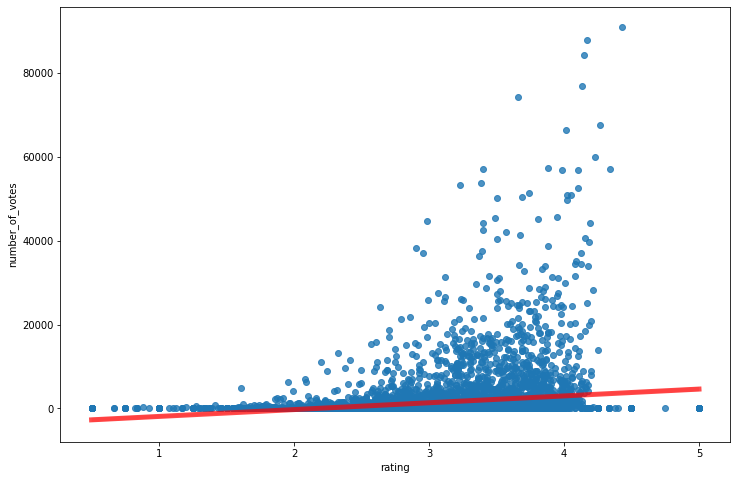

In [37]:
plt.figure(figsize=(12,8))
sns.regplot(x='rating', y='number_of_votes',data=ratings_avg_count, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

**There is a slight positive correlation between the average rating of a movie and the number of votes. According to the graph:<br> 1. Movies with higher average ratings actually have more number of ratings.**<br>
**2. If a movie gets more number of votes, the average rating would increase slightly**

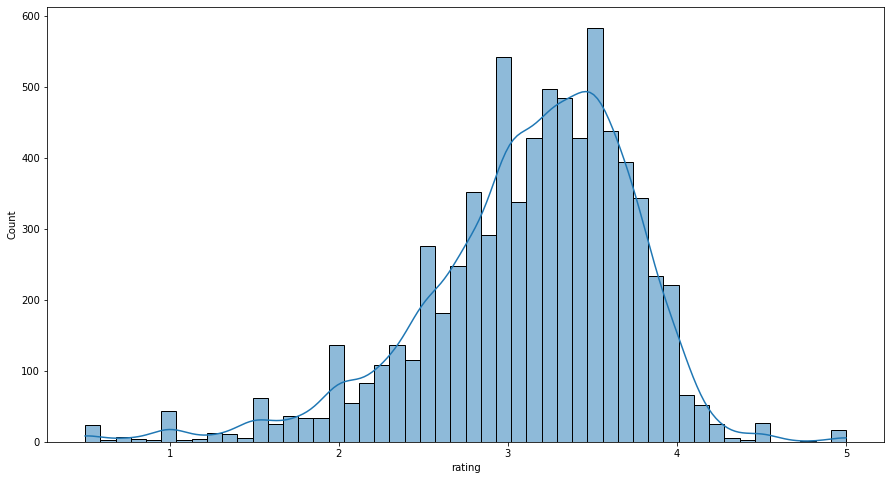

In [54]:
plt.figure(figsize=(15,8))
plt.rcParams['patch.force_edgecolor'] = True
sns.histplot(data=ratings_avg_count, x="rating",bins=50, kde=True)
plt.show()

**According to the graph the data has a weak normal distribution with the mean around 3.5 due to the presence of outliers in the data. In addition, values of format x and x.5 (where x is a number between 1 - 5) are assigned by users much more often than other float values**